# Auto-graded section

You will optimize the complexity of regression models in terms of information criteria and smoothness. In problem **1**, you will see the trade-off between model performance and model complexity. In problems **2** and **3**, ridge regression will be covered along with hyperparameter tuning.

The block below defines the necessary variables and shows a plot of the portion of the IR spectrum that you will work with in this assignment:

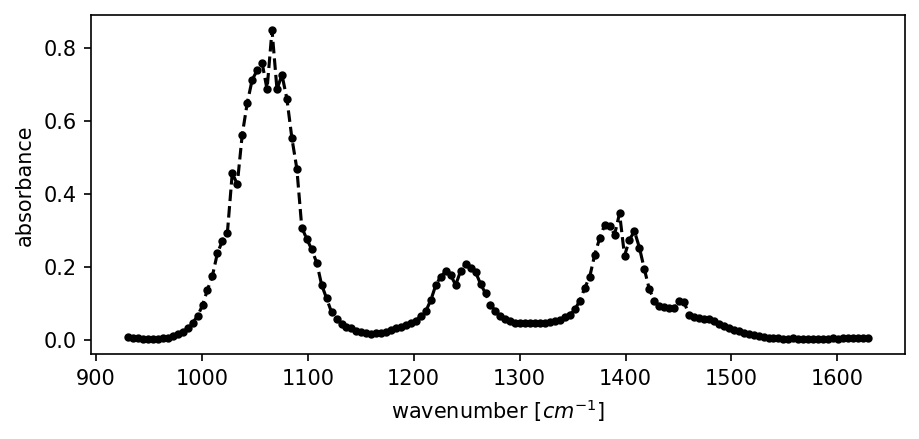

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[100:250].reshape(-1)
y_peak = df['absorbance'].values[100:250]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Bayesian Information Criteria (20 pts)

Given normally distributed prediction errors, the **Bayesian Information Criteria** (BIC) is computed as:

$\mathrm{BIC}=n\times ln\left(\sigma_e^2\right)+k\times ln\left(n\right)$

where $n$ is the number of data points, $\sigma_e$ is the standard deviation of the error, and $k$ is the number of parameters. You will revisit the evenly spaced Gaussians features from the last module and see how the complexity varies with respect to the number of Gaussians. The positions and widths of Gaussians will be known values in which case their weights are the only parameters to be optimized (i.e. $k$ = the number of Gaussians).

Let's first recreate the `gaussian_features` function. It generates `N` evenly-spaced Gaussians with a fixed width `sigma` in a given range of `x`. The return value `features` should be an array (or matrix) with dimensions of (length of `x` X `N`). The default value of `sigma` is set to 25 for you. (7.5 pts)

In [2]:
def gaussian_features(x, N, sigma = 25):
########################################################
    x = x.reshape(-1)
    xdata = np.linspace(min(x), max(x), N)
    features = []
    for i in xdata:
        features.append(np.exp(-(x-i)**2/(2*sigma**2)))
########################################################
    return np.array(features).T

In [3]:
assert gaussian_features(x_peak, 8, sigma = 25).shape == (150, 8)
assert np.isclose(np.linalg.norm(gaussian_features(y_peak, 30, 25)), 67.07229883806694)

Create a function `BIC` that returns the BIC for a given true value `y` and predicted value `y_hat`. `BIC` takes three arguments: (5 pts)

- `y`: true value (1-D numpy array)
- `y_hat`: predicted value (1-D numpy array)
- `k`: the number of parameters (float)

In [4]:
def BIC(y, y_hat, k):
##############################################
    n = len(y)
    stdv = np.std(y_hat - y, ddof = 0)
    bic = n * np.log(stdv**2) + k * np.log(n)
##############################################
    return bic

In [5]:
assert np.isclose(BIC(x_peak, y_peak, 10), 1644.1236582971526), "wrong BIC"

You will compare the BIC's with respect to the number of Gaussians `N`. The following is the expected training procedure for each `N`:

- Declare a LinearRegression() model
- Create Gaussian features for `x_peak`
- Train a LinearRegression() model with created Gaussian features
- Get predictions from created Gaussian features
- Compute the BIC

Finally, you will find the optimum number of Gaussians that gives you the lowest BIC. Determine the optimum `N` out of [2, 4, 8, 16, 32, 64]. Save the BICs for each `N` in the **list** `BICs` (2.5 pts) and save the optimum `N` as `opt_N` (5 pts).

***Hint***: Be careful of intercept fitting. We want the number of parameters to be identical to the number of Gaussians. Think how the intercept fitting (or changing the `fit_intercept` argument) will affect the number of parameters.

In [6]:
N = [2, 4, 8, 16, 32, 64, 128]

In [9]:
########################################################################
from sklearn.linear_model import LinearRegression

BICs = np.zeros(len(N))

for i in range(len(N)):
    basis = gaussian_features(x_peak.reshape(-1,1), N[i], sigma =25)
    lr = LinearRegression(fit_intercept = False).fit(basis, y_peak)
    y_hat = lr.predict(basis)
    BICs[i] = BIC(y_peak, y_hat, k = N[i])
    if min(BICs)==BICs[i]:
        opt_N = N[i]
BICs = np.ndarray.tolist(BICs)
#######################################################################

In [10]:
assert type(BICs) == list, "BICs is not a list"
assert np.isclose(np.linalg.norm(BICs), 2001.2845818517449), "BICs not correct"

AssertionError: BICs not correct

In [11]:
assert np.isclose(x_peak[N.index(opt_N)], 949.063181), "opt_N not correct"

## 2. Hyperparameter Tuning (15 pts)

In this problem, you will tune one hyperparameter (`alpha`) of a kernel ridge regression model using hold-out.

Reshape `x_peak` and `y_peak` into 100 x 1 2-D numpy array. (7.5 pts)

In [12]:
########################################
x_peak = np.array(x_peak.reshape(-1,1))
y_peak = np.array(y_peak.reshape(-1,1))
########################################

In [13]:
assert x_peak.shape[0] * y_peak.shape[1] == 150

We have imported `KernelRidge` and `train_test_split` for you. Split `x_peak` and `y_peak` to `x_train`, `x_test`, `y_train`, and `y_test` using `train_test_split`. The `test_size` and `random_state` should be `0.3` and `42`, respectively. (5 pts)

***Note***: If you fail to set a proper `random_state`, you won't pass any assertion tests for the following problems.

In [14]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

In [15]:
#####################################################################################
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = 0.3)
#####################################################################################

In [16]:
assert np.isclose(np.linalg.norm(x_train) * np.linalg.norm(y_test), 26584.91466987621), "wrong data split"

You will find the optimum `alpha` out of [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]. The following is the expected training steps for each `alpha`:

- Declare a `KernelRidge(kernel = 'rbf', gamma = 0.005)` model
- Train the model on the training set
- Get $\mathrm{r^2}$ on the test set

The optimum `alpha` is the one that gives you the highest $\mathrm{r^2}$ on the test set. Report the optimum as `opt_alpha` and the highest $\mathrm{r^2}$ as `opt_r2`. (2.5 pts)

In [17]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

In [18]:
##############################################################################################
r2 = np.zeros(len(alphas))
for i in range(len(alphas)):
    KRR = KernelRidge(alpha = alphas[i], kernel = 'rbf', gamma = 0.005).fit(x_train, y_train)
    r2[i] = KRR.score(x_test, y_test)
    if max(r2)==r2[i]:
        opt_alpha = alphas[i]
opt_r2 = max(r2)
##############################################################################################

In [19]:
assert np.isclose(opt_r2**2 * opt_alpha**3, 8.693684997565984e-07)

## 3. GridSearchCV (15 pts)

You will optimize multiple hyperparameters in a kernel ridge regression using `GridSearchCV` in this case.

Let's first import `GridSearchCV`. (7.5 pts)

In [20]:
#################################################
from sklearn.model_selection import GridSearchCV
#################################################

In [21]:
assert GridSearchCV.__init__

Unlike train_test_split, GridSearchCV does not shuffle the data by default even though it actually supports k-fold cross validation. The impact of shuffling be covered in the homework. For now, we will shuffle x_peak and y_peak for you before using GridSearchCV.

In [22]:
from sklearn.utils import shuffle

x_shuffle, y_shuffle = shuffle(x_peak, y_peak, random_state = 3)

You will the find the best hyperparameter combination of `alpha` and `gamma`. Below we have provided the candidates of `alpha` and `sigma` (where $\gamma = \frac{1}{2\sigma^2}$). Create a parameter dictionary `param_grid` that will be input to a `GridSearchCV`. (5 pts)

**Hint:** Remember that the dictionary keys must be identical to the keyword arguments of the model, so you cannot use `sigma` directly.

In [23]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
sigmas = [100, 150, 200, 250, 300, 350, 400, 450, 500]

In [24]:
###################################################
sigmas = np.array(sigmas)
gammas = 1./2/sigmas**2
param_grid = {'alpha' : alphas, 'gamma' : gammas}
###################################################

In [25]:
assert type(param_grid) == dict, "param_grid is not a dictionary"
assert set(param_grid.keys()) == {'alpha', 'gamma'}, "wrong param_grid"

Using `GridSearchCV` and `KernelRidge(kernel = 'rbf')`, find the optimum `alpha` and `gamma`. You need to use 5-fold cross validation during hyperparameter tuning. Report the optimum `alpha` as `alpha_opt` and the optimum `gamma` as `gamma_opt`. (2.5 pts)

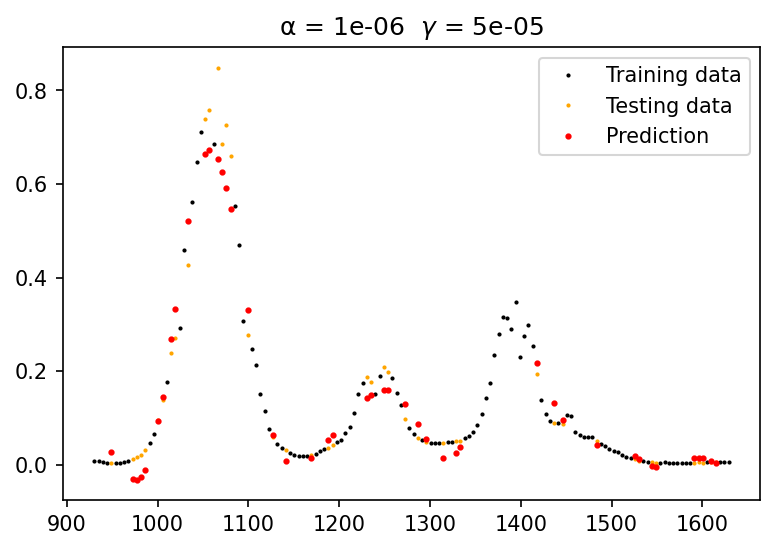

In [26]:
#################################################################################################################
KRR = KernelRidge(kernel = 'rbf')
KRR_search = GridSearchCV(KRR, param_grid, cv =5) ### 5-fold cross-validation
KRR_search.fit(x_train, y_train)
yhat_KRR = KRR_search.best_estimator_.predict(x_test)

alpha_opt = KRR_search.best_estimator_.alpha
gamma_opt = KRR_search.best_estimator_.gamma

fig, ax = plt.subplots(figsize=(6,4), dpi =150)
ax.plot(x_train,y_train, marker ='o', markersize =1, ls ='', label = 'Training data', color='k')
ax.plot(x_test,y_test, marker ='o', markersize =1, ls ='', label = 'Testing data', color = 'orange')
ax.plot(x_test, yhat_KRR, marker ='o', markersize =2, linewidth = 0.8, ls ='', color ='r', label = 'Prediction')
ax.set_title('\u03B1 = '+ str(alpha_opt) + '  $\gamma$ = '+ str(gamma_opt) )
ax.legend()
plt.show()
#################################################################################################################

In [27]:
assert np.isclose(np.log10(alpha_opt) * np.log10(gamma_opt), 25.806179973983888)

# Peer-graded

In this section, we will work with a different subset of the ethanol spectrum data loaded below:

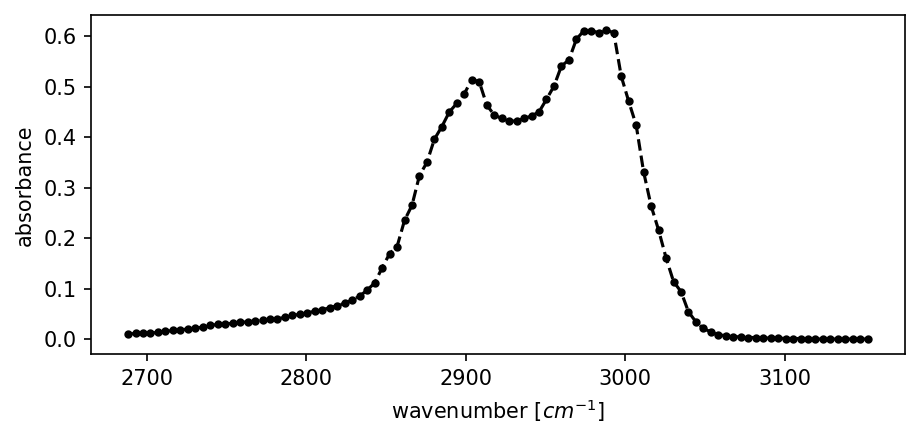

In [28]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1)
y_peak = df['absorbance'].values[475:575]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. LASSO Regularization and Hyperparameter Tuning

You will make use of a LASSO regression and tune its hyperparameters. You will optimize `alpha` and `gamma` as you did in the previous section. However, there is no "KernelLASSO" model implemented in `scikit-learn`, so you will need to construct the kernel manually, then use the kernel matrix as input to the `scikit-learn` LASSO implementation. Note that since `gamma` is a hyperparameter of the RBF kernel, you will need to optimize it outside of the regression model.

Below are the requirements of this problem.

- Consider **at least 5** candidates for each `alpha` and `gamma`. You may select these candidates however you see fit, and may use trial and error to identify the best candidates.
- Use hold-out cross-validation with 30% of the dataset as the test set.

***Hint***
- Using `GridSearchCV` may make the problem even harder. Manually optimizing with `for` loops is an acceptable strategy.
- This [document](https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html) provides a way to customize the line style.
- You may create your own `rbf` function or use `sklearn.metrics.pairwise.rbf_kernel`. Please read the [official document](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html) of the `rbf_kernel` function **carefully** when you try to use it.
- Be mindful of **data leakage** to the test set. Applying an RBF kernel to the dataset before splitting it possesses a risk of data leakge, which is regarded as a from of "cheating" in machine learning. The test set must be kept totally separate from the training set so that the model does not know anything about the test set.

### 1a. Model Optimization
Find the optimum model using hyperparameter optimization. It should be possible to find a model that has an $\mathrm{r^2}$ of at least 0.8 on the test set.

Report the optimum `alpha` and `gamma`, along with the optimium $r^2$ and MAE values.

Best values of α: 1e-05 and γ: 0.005 with a r² : 0.9984876381708877


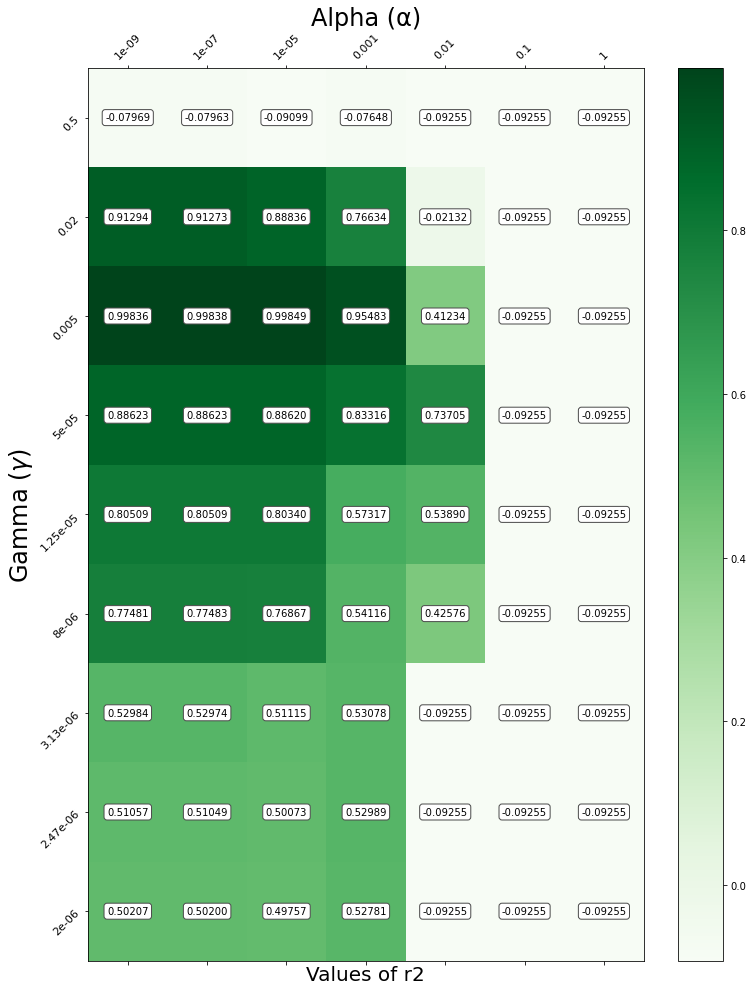

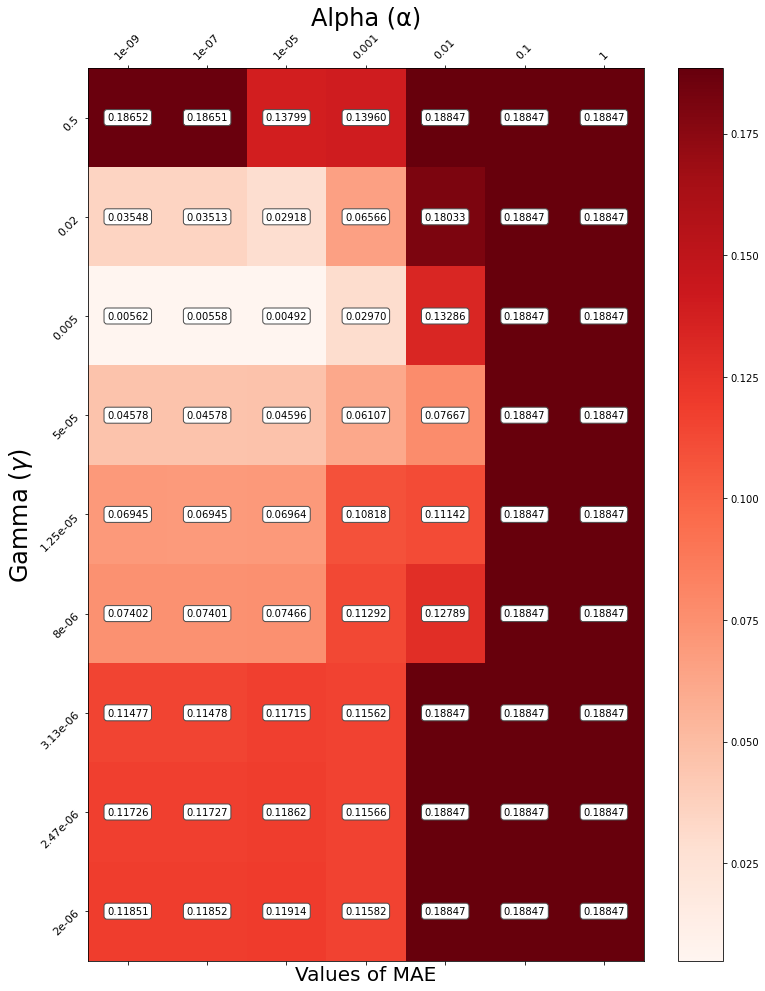

In [38]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

x_peak = x_peak.reshape(-1,1)
np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = 0.3)  ### 30% hold-out CV 

alphas = [1e-9, 1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1]
sigmas = [1, 5, 10, 100, 200, 250, 400, 450, 500]
sigmas = np.array(sigmas)
gammas = 1./2/sigmas**2

r2 = np.zeros((len(alphas), len(gammas)))
MAE = np.zeros((len(alphas), len(gammas)))

for i in range(len(alphas)):
    for j in range(len(gammas)):
        ### training
        basis = rbf_kernel(x_train, x_train, gamma = gammas[j])
        LASSO = Lasso(alpha =alphas[i])
        LASSO.fit(basis, y_train)
        
        ### testing
        basis1 = rbf_kernel(x_test, x_train, gamma = gammas[j]) ### the func arg are switched in the func defn
        yhat_LASSO = LASSO.predict(basis1)
        r2[i,j] = r2_score(y_test, yhat_LASSO) 
        MAE[i,j] = mean_absolute_error(y_test, yhat_LASSO) 
        if r2[i,j]==np.max(r2):
            alpha = i
            gamma = j
for i in range(len(gammas)):
    gammas[i] = f"{gammas[i]:.2e}"

########## Plotting r2 values wrt alpha and gamma values

plt.rcParams["figure.figsize"] = (20,16)
plt.matshow(r2.T,cmap = "Greens", aspect ='auto')
plt.xticks(np.arange(len(alphas)), alphas, fontsize=11, rotation=45) 
plt.yticks(np.arange(len(gammas)), gammas, fontsize=11, rotation=45)
plt.colorbar()
plt.title('Alpha (\u03B1)', fontsize = 24)
plt.ylabel('Gamma ($\gamma$)', fontsize = 24)
plt.xlabel('Values of r2', fontsize = 20)
for (x, y), value in np.ndenumerate(r2):
    plt.text(x, y, f"{value:.5f}", va="center", ha="center",\
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), fontsize=10)

########## Plotting MAE values wrt alpha and gamma values

plt.rcParams["figure.figsize"] = (20,16)
plt.matshow(MAE.T,cmap = "Reds", aspect ='auto')
plt.xticks(np.arange(len(alphas)), alphas, fontsize=11, rotation=45) 
plt.yticks(np.arange(len(gammas)), gammas, fontsize=11, rotation=45)
plt.colorbar()
plt.title('Alpha (\u03B1)', fontsize = 24)
plt.ylabel('Gamma ($\gamma$)', fontsize = 24)
plt.xlabel('Values of MAE', fontsize = 20)
for (x, y), value in np.ndenumerate(MAE):
    plt.text(x, y, f"{value:.5f}", va="center", ha="center",\
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), fontsize=10)

print('Best values of \u03B1: '+str(alphas[alpha])+' and \u03B3: '+ str(gammas[gamma])+' with a r\u00b2 : '+str(np.max(r2)))

### 1b. Model visualization
Visualization of a model is a great way to assess its validity.  Plot the following outputs from the optimum model on a single figure.

* predictions on the training set in blue solid dots
* predictions on the test set in red solid dots
* the original data in black solid line

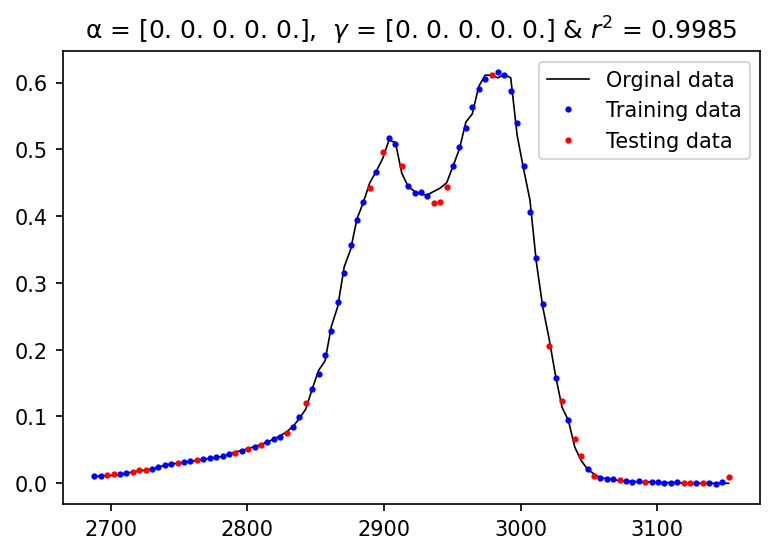

In [39]:
### training
basis = rbf_kernel(x_train, x_train, gamma = gammas[gamma])
LASSO = Lasso(alpha =alphas[alpha])
LASSO.fit(basis, y_train)
yhat_train = LASSO.predict(basis)
r2train = r2_score(y_train, yhat_train) 

### testing
basis1 = rbf_kernel(x_test, x_train, gamma = gammas[gamma]) ### the func arg are switched in the func defn
yhat_test = LASSO.predict(basis1)
r2train = r2_score(y_test, yhat_test) 

fig, ax = plt.subplots(figsize=(6,4), dpi =150)
ax.plot(x_peak, y_peak, linewidth = 0.8, ls ='-', color ='k', label = 'Orginal data')
ax.plot(x_train,yhat_train, marker ='o', markersize =2, ls ='', label = 'Training data', color='b')
ax.plot(x_test,yhat_test, marker ='o', markersize =2, ls ='', label = 'Testing data', color = 'r')
ax.set_title('\u03B1 = '+ str(alpha_opt) + ',  $\gamma$ = '+ str(gamma_opt) + ' & $r^2$ = {:.4f}'.format(r2[alpha,gamma]) )
ax.legend()
plt.show()

### 1c. Model interpretation

How many coefficients does the optimum model have? How would you interpret those coefficients in terms of the peaks of the spectrum?

Please briefly explain in 2-3 sentences.

Number of coeff:  70
Number of non-zero coeffs:  52


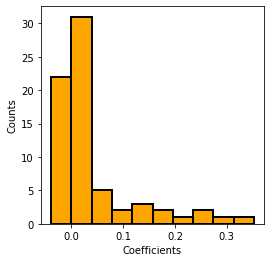

In [40]:
print('Number of coeff: ', len(LASSO.coef_))

plt.rcParams["figure.figsize"] = (4,4)
plt.hist(LASSO.coef_, edgecolor='k', linewidth=2, color ='orange')
plt.xlabel('Coefficients')
plt.ylabel('Counts')

zeros = [f for f in np.isclose(LASSO.coef_,0) if f == True]
print('Number of non-zero coeffs: ', len(LASSO.coef_) - len(zeros))

**Answer:** As seen above, the model has 70 coefficeints in total of which 52 are non-zero. This might be correct as the coefficients corresponding to the data points in the tail end of the spectra should be 0 as the peaks exists only in the middle.

## 2. Shuffling and Cross Validation

In the auto-graded section, shuffling preceded `GridSearchCV`. In this problem, you will see what happens when shuffling does not occur prior to k-fold cross validation (and why it is necessary for this dataset). 

* Use the `KFold` class to perform 5-fold cross validation directly on the spectrum data. By declaring `KFold(n_splits = 5, shuffle = False)`, the k-fold object splits the dataset into 5 consecutive folds. This means the first fold will use the first 20% of the data for testing, and the next 20% will be the testing data for the second fold, and so forth.

* For each of the 5 data splits, create an independently optimized `KernelRidge` model. For each split, you should train the model with 80% of the data and test it on 20%. Use `GridSearchCV` to optimize `gamma` and `alpha` separately for each split. You may select the ranges over which to optimize `gamma` and `alpha`. The result should be 5 separate `KernelRidge` models, each trained to a different 80% of the data, and each one with potentially different hyperparameters.

### 2a. Visualization and analysis of models


Report the $r^2$ value using the entire `x_peak` dataset with each model. Plot the prediction of each model with different colors on a single plot, and include the original data as a black line.

In [42]:
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
sigmas = [100, 150, 200, 250, 300, 350, 400, 450, 500]
gammas = 1./(2*np.power(sigmas,2))
#print(gammas)

kf = KFold(n_splits = 5, shuffle = False)

alpha_opt = np.zeros(5) #each split will generate its own alpha_opt 
gamma_opt = np.zeros(5)
r2_opt = np.zeros(5)
yhat_opt = np.zeros((len(x_peak),5)) 

i=1
while i<len():
    for trainindex, testindex in kf.split(x_peak):
        x_train, x_test = x_peak[trainindex], x_peak[testindex]
        y_train, y_test = y_peak[trainindex], y_peak[testindex]

        param_grid = {'alpha' : alphas, 'gamma' : gammas}

        KRR = KernelRidge(kernel = 'rbf')
        KRR_search = GridSearchCV(KRR, param_grid, cv =5) # 5-fold cross-validation
        #training 
        KRR_search.fit(x_train, y_train)

        #predicting 
        yhat_opt[:,i-1] = KRR_search.best_estimator_.predict(x_peak) #i-1 because by default python starts with zero 

        alpha_opt[i-1] = KRR_search.best_estimator_.alpha
        gamma_opt[i-1] = KRR_search.best_estimator_.gamma
        r2_opt[i-1] = KRR_search.best_score_
    
        x_peak.sort()
        ax.plot(x_peak, yhat_opt[:,i-1], marker = 'o', markersize =3, ls ='--', label = str(i)+'-fold dataset')
        ax.set_title('KRR model fits for 5-fold CV with best \u03B1 and $\gamma$ from GridsearhCV')
        ax.set_xlabel('wavenumber [$cm^{-1}$]')
        ax.set_ylabel('absorbance')
        ax.legend()
        i+=1
        
rows =  [('Best estimator from kFold set:' + str(k+1)) for k in range(5)]
print(pd.DataFrame(np.column_stack((alpha_opt, gamma_opt, r2_opt)), columns = ['optimum alpha','optimum gamma','r^2 value'] , index = rows))
plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

### 2b. Variance between models

Plot the standard deviation of the 5 model predictions as a function of wavenumber (i.e. the x-axis is wavenumber and the y-axis is the standard deviation of the 5 different predictions from each model).

Text(0, 0.5, 'Standard deviation (σ)')

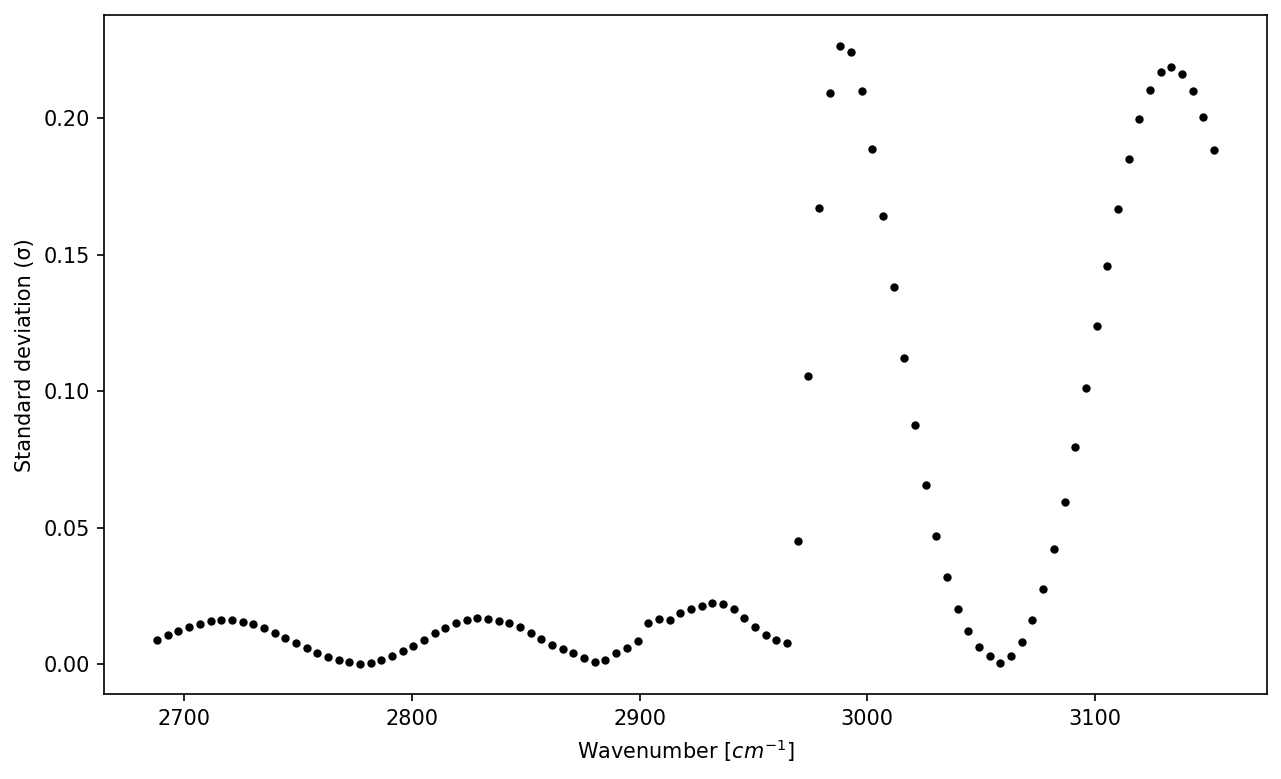

In [33]:
fig, ax = plt.subplots(figsize=(10,6), dpi =150)
ax.plot(x_peak,np.std(yhat_opt, axis =1), marker = 'o', markersize =3, ls ='', label = 'Original data', color='k')
ax.set_xlabel('Wavenumber [$cm^{-1}$]')
ax.set_ylabel('Standard deviation (\u03C3)')

### 2c. Homoscedasticity

Is the prediction error from the different models homoscedastic? Briefly explain why.

**Answer:** It can be clearly seen from above that the data is not Homoscedastic given the std deviation values increase with the independant variable (wavenumbers) as seen above.

### 2d. Model evaluation

Which model is most reliable? Why is it necessary to "shuffle" the data during k-fold cross-validation in this case?

**Answer:** Shuffled data model is the best model. Among the unshuffled model data 2nd fold seems to be the best fit given the visual verifiation and by r2 values.

Shuffling is important, This is becasue, if the test data is selected in sequence and hid from the training data, then the model has no data available that region, and the predictions corresponding to that region may end up being very poor. From the plots below, this can be clearly seen, that in the region where there is no training data model fit is really bad, but is excellent in the other regions.

In [ ]:
def rbf_kernel_reg(xtrain, xtest = None, gamma = 1):
    if xtest is None:
        xtest=xtrain
    N=len(xtrain)
    M=len(xtest)
    X= np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            X[i,j] = np.exp(-gamma*(xtest[i]-xtrain[j])**2)
    return X

from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = False)  ### shuffle randomly selects data instead of selecting consecutive datapoints
### this is a 5-fold cross-validation

i=0
fig, ax = plt.subplots(1,5, figsize = (20,4), dpi =150)

for trainindex, testindex in kf.split(x_peak):
    x_train, x_test = x_peak[trainindex], x_peak[testindex]
    y_train, y_test = y_peak[trainindex], y_peak[testindex]
    
    sigma = 50
    gamma = 1/2/sigma**2

    basis = rbf_kernel_reg(x_train, gamma = gamma)
    model = LinearRegression(fit_intercept = True).fit(basis, y_train)
    yhattrain = model.predict(basis)

    basis1 = rbf_kernel_reg(x_train, xtest = x_test, gamma = gamma)
    yhattest = model.predict(basis1)
    
    ax[i].plot(x_peak, y_peak, marker = 'o', markersize =3, ls='', label = 'Original Data')
    ax[i].plot(x_train, y_train, marker = 'o', markersize =1.2, ls='', label = 'Training Data')
    ax[i].plot(x_test, yhattest, ls='dotted', linewidth = 1, label = str(i+1)+'th fold CV Predict', color ='k')
    ax[i].set_ylim([-2,2])
    ax[i].legend()
    i+=1
plt.show()